# Causal reasoning in dynamical systems

## Outline

- [Setup](#setup)

- [Overview: Causal Inference in Continuous Time Dynamical Systems](#overview:-causal-inference-in-continuous-time-dynamical-systems)
    - [Task: Modeling Causal Interventions in Continuous Time Systems](#task:-modeling-causal-interventions-in-continuous-time-systems)
    - [Challenge: Representational Complexities of ODEs in Causal Inference](#challenge:-representational-complexities-of-odes-in-causal-inference)
    - [Assumptions: Deterministic Dynamics and No Latent Confounders](#assumptions:-deterministic-dynamics-and-no-latent-confounders)
    - [Intuition: Understanding Interventions in Dynamical Systems](#intuition:-understanding-interventions-in-dynamical-systems)

- [Example: Assessing Intervention Strategies in an Epidemic Model](#example:-assessing-intervention-strategies-in-an-epidemic-model)
    - [Variables](#variables)
    - [Motivation](#motivation)
    - [Source](#source)

- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model Description](#model-description)
    - [Observation Model](#observation-model)
    - [Generating Synthetic Disease Data using simulate](#generating-synthetic-disease-data-using-simulate)
    - [Informal Prior Predictive Check: Visualizing Samples](#informal-prior-predictive-check---visualizing-samples)

- [Probabilistic Inference over Dynamical System Parameters](#probabilistic-inference-over-dynamical-system-parameters)
    - [Informal Posterior Predictive Check: Visualizing Samples](#informal-posterior-predictive-check---visualizing-samples)

- [Exploring Interventions](#exploring-interventions)
    - [Modeling a Deterministic Intervention](#modeling-a-deterministic-intervention)
    - [Modeling an Uncertain Intervention](#modeling-an-uncertain-intervention)
    - [Modeling a State-Dependent Intervention](#modeling-a-state-dependent-intervention)
    - [Modeling a State-Dependent Intervention with Uncertainty](#modeling-a-state-dependent-intervention-with-uncertainty)

- [References](#references)


## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [2]:
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal

from chirho.dynamical.handlers import (
    LogTrajectory,
    StaticBatchObservation,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition
from chirho.interventional.ops import intervene

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = ('CI' in os.environ)
num_steps = 10 if smoke_test else 200
num_samples = 10 if smoke_test else 100

## Overview: Causal Inference in Continuous Time Dynamical Systems

### **Task:** Modeling Causal Interventions in Continuous Time Systems
This tutorial focuses on estimating the effects of interventions in systems described by continuous time dynamics. We use ChiRho to model scenarios where interventions occur at specific moments in time, impacting the trajectory of a system governed by ordinary differential equations (ODEs). This approach is particularly relevant for complex systems in physics, biology, and engineering where time-continuous processes are fundamental representations of cause-effect mechanistic knowledge.

### **Challenge:** Representational Complexities of ODEs in Causal Inference
ODEs inherently contain causal semantics, as they describe how changes in one variable lead to changes in others over continuous time. However, they do not map directly onto causal graphical models, which do not provide a direct semantics of time. This means that the algorithms that commonly operate on causal graph data structures, such as the do-calculus, do not apply. Rather than abandon these models as out-of-scope for existing data structures, we instead extend the intervention semantics in ChiRho for this broad model family.

### **Assumptions:** Deterministic Dynamics and No Latent Confounders
In this tutorial, we make several key assumptions. First, we assume that all dynamics in the system are deterministic, meaning that the system's behavior can be precisely described by its current state and the governing equations without random variability. Secondly, we assume that the dynamical system model accurately captures the real-world processes it is intended to represent. This includes the correct formulation of the ODEs and a comprehensive representation of all relevant variables and their interactions. Lastly, we assume that there are no confounders between the model parameters. This means that the parameters are not influenced by unobserved variables that could bias our causal estimates. In subsequent tutorials we'll relax these assumptions.

### **Intuition:** Understanding Interventions in Dynamical Systems

ChiRho tackles these representational challenges by providing a generic semantics of interventions in continuous time dynamical systems by interrupting and modifying the behavior of simulation runs. Using this semantics of intervention with continuous-time systems allows ChiRho to provide automated support for common interventional and counterfactual questions described throughout the causal inference literature in these settings. In other words, once we provide an intervention semantics for continuous-time dynamical systems in ChiRho, we get all of ChiRho's causal reasoning functionality for these problems "for free". In addition, as  we'll see in subsequent tutorials, providing an intervention semantics for continuous time dynamical systems makes it almost trivial to define hybrid models that combine continuous time component (e.g. disease dynamics) with atemporal components (hierarchical regression).

The key intuition behind this approach is that interventions in continuous time systems can be represented as alterations to the parameters or state variables in the ODEs at some moment in time. In other words, intervening on an ODE at time $t$ involves (i) simulating up until $t$, (ii) modifying the terminal state from the initial simulation $X(t) = do(X(t), X')$, and (iii) simulating forward from the (intervened) $X(t)$ until the end of the full simulation. By simulating how these changes propagate through the system over time, we can estimate the causal effect of interventions.

## Example: Assessing Intervention Strategies in an Epidemic Model

### Variables

In this example, we will explore the SIR (Susceptible, Infected, Recovered) compartmental model, a fundamental model in epidemiology. Here, the variables of interest are:

- $S(t)$: the number of susceptible individuals at time $t$,

- $I(t)$: the number of infected individuals at time $t$, and

- $R(t)$: the number of recovered individuals at time $t$.

These compartments interact through a set of ordinary differential equations that describe the rate at which individuals move from being susceptible to infected, and from infected to recovered.

### Motivation

Understanding the impact of different public health interventions on the spread of an infectious disease is crucial for policymakers and health officials. For example, policymakers may wish to predict the impacts of mask mandates, social distancing campaigns, or vaccination efforts. By simulating these interventions in the model, we can estimate their impact on the epidemic trajectory, such as changes in the peak infection rate or the total number of infections over time. In this example we'll see how to model such interventions using ChiRho.

### Source

For our example, we will use simulated data that follows the dynamics of the SIR model.

## Causal Probabilistic Program

In this section, we encode our causal assumptions about disease dynamics using an ordinary differential equation embedded in Pyro. To do this we'll first implement a `PyroModule` that describes the differential expressions declaratively, and then use a `ChiRho.dynamics.handlers.Solver` such as `TorchDiffEq` to solve the differential equation. Later in this example we'll extend the model with uncertainty.

### Model Description

The `SIRDynamics` class encapsulates the dynamics of the SIR model. The model is defined by two key parameters: `beta` and `gamma`. These parameters govern the rate of infection and recovery, respectively. The `diff` method in the class defines the differential equations for the Susceptible (`S`), Infected (`I`), and Recovered (`R`) compartments. Specifically:

- The rate of change of `S` is given by `-self.beta * X["S"] * X["I"]`, representing the transition of susceptible individuals to the infected state.

- The rate of change of `I` is `self.beta * X["S"] * X["I"] - self.gamma * X["I"]`, capturing both new infections and recoveries.

- The rate of change of `R` is `self.gamma * X["I"]`, representing the transition from infected to recovered.

These equations encapsulate the causal relationships within the SIR model, where the number of susceptible and infected individuals causally influences the dynamics of the disease spread.

### Observation Model

The `sirv_observation_model` models how noisy data is generated from (latent) disease dynamics. In this model, we only observe the number of infected (`I_obs`) and recovered (`R_obs`) individuals. These observations are modeled as Poisson-distributed, capturing the inherent variability and uncertainty in real-world observations of infectious diseases.


In [6]:
from chirho.indexed.ops import gather, indices_of

def intervened(param, state, state_name, intervention_name):
    # TODO: replace this with some subset utility ...
    if intervention_name not in indices_of(param):
        return state[state_name]
    else:
        print(indices_of(param))
        return intervene(state[state_name], 
                         gather(state[state_name], {intervention_name:{1}}), 
                         name=state_name)

class SIRVDynamics(pyro.nn.PyroModule):
    def __init__(self, beta_V, beta_nV, gamma, alpha):
        super().__init__()
        self.beta_V = beta_V
        self.beta_nV = beta_nV
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, X: State[torch.Tensor]) -> State[torch.Tensor]:
        dX = dict()
        T1 = self.alpha * X["S_nV"] # people become vaccinated
        T2 = self.beta_V * X["S_V"] * X["I_V"] # infection of vaccinated by vaccinated
        T3 = self.beta_V * X["S_V"] * X["I_nV"] # infection of vaccinated by unvaccinated
        T4 = self.beta_nV * X["S_nV"] * intervened(self.alpha, X, "I_nV", "alpha") # infection of unvaccinated by unvaccinated
        T5 = self.beta_nV * X["S_nV"] * X["I_V"] # infection of unvaccinated by vaccinated
        T6 = self.gamma * X["I_V"] # recovery of vaccinated people
        T7 = self.gamma * X["I_nV"] # recovery of unvaccinated people

        dX["S_nV"] = - T1 - T4 - T5
        dX["I_nV"] = T4 + T5 - T7
        dX["S_V"] = T1 - T2 - T3
        dX["I_V"] = T2 + T3 - T6
        dX["R"] = T6 + T7

        return dX

def sirv_observation_model(X: State[torch.Tensor]) -> None:
    # We don't observe the number of susceptible individuals directly.
    
    # Note: Here we set the event_dim to 1 if the last dimension of X["I_V"] is > 1, as the sirv_observation_model
    # can be used for both single and multi-dimensional observations.
    assert X["I_V"].shape == X["I_nV"].shape == X["R"].shape
    event_dim = 1 if X["I_V"].shape and X["I_V"].shape[-1] > 1 else 0
    pyro.sample("I_V_obs", dist.Poisson(X["I_V"]).to_event(event_dim))  # noisy number of infected vaccinated actually observed
    pyro.sample("I_nV_obs", dist.Poisson(X["I_nV"]).to_event(event_dim))  # noisy number of infected not vaccinated actually observed
    pyro.sample("R_obs", dist.Poisson(X["R"]).to_event(event_dim))  # noisy number of recovered actually observed

### Generating Synthetic Disease Data using `simulate`

Using our `SIRDynamics` model, we can generate synthetic data both for the (latent) true dynamics, as well as the noisy observations. In this scenario
we'll assume that the epidemic began at $t=0$, we gather measurements from $t=0.5$ to $t=1$ months, and that we are interesting in forecasting disease dynamics until $t=3$ months.

For this scenario we'll assume that the true infection rate is $\beta=0.03$ and the true recovery rate is $\gamma=0.5$.

**Note:** Here we use a new effectful operation introduced in the `chirho.dynamical` module, `simulate`, which solves the differential equation passed as the `dynamics` argument. Similar to `pyro.sample`, `simulate`'s behavior can be modified using several effect handlers. In the following code snippet we show a `Solver` handler, `TorchDiffEq`, which wraps the torchdiffeq.py (https://github.com/rtqichen/torchdiffeq) package for solving ODEs for use with `chirho`. In addition, we use the `LogTrajectory` handler to store the results of the simulation at multiple points in time, rather than the default behavior of just returning the terminal state.

In [7]:
# Assume there is initially a population of 99 million people that are susceptible, 1 million infected, and 0 recovered
init_state = dict(S_nV = torch.tensor(99.0), 
                  S_V  = torch.tensor(0.),
                  I_nV = torch.tensor(1.0), 
                  I_V  = torch.tensor(0.0), 
                  R    = torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(6.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)

# We now simulate from the SIR model
beta_V_true = torch.tensor(0.02)
beta_nV_true = torch.tensor(0.03)
gamma_true = torch.tensor(0.5)
alpha_true = torch.tensor(0.2)
sirv_true = SIRVDynamics(beta_V_true, beta_nV_true, gamma_true, alpha_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sirv_true, init_state, start_time, end_time)

sirv_true_traj = lt.trajectory

obs_start_time = torch.tensor(1.) # Measurements start 0.5 month into the pandemic
obs_sample_rate = torch.tensor(1/30) # Take measurements one per day
obs_end_time = torch.tensor(3.0) # Measurements end after 1st month

obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with TorchDiffEq(), LogTrajectory(obs_logging_times) as lt_obs:
    simulate(sirv_true, init_state, start_time, obs_end_time)

sirv_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    sirv_observation_model(sirv_obs_traj)

sirv_data = dict(**{k:tr.trace.nodes[k]["value"] for k in ["I_V_obs", "I_nV_obs", "R_obs"]})

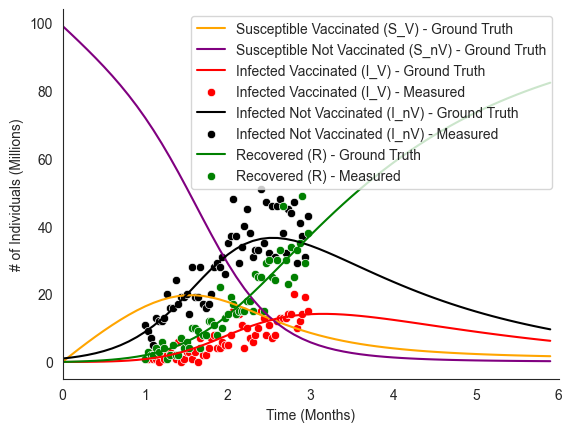

In [8]:
# TODO: revise this plot

sns.lineplot(
    x=logging_times, y=sirv_true_traj["S_V"], label="Susceptible Vaccinated (S_V) - Ground Truth", color="orange"
)
sns.lineplot(
    x=logging_times, y=sirv_true_traj["S_nV"], label="Susceptible Not Vaccinated (S_nV) - Ground Truth", color="purple"
)
sns.lineplot(x=logging_times, y=sirv_true_traj["I_V"], label="Infected Vaccinated (I_V) - Ground Truth", color="red")
sns.scatterplot(x=obs_logging_times, y=sirv_data["I_V_obs"], label="Infected Vaccinated (I_V) - Measured", color="red")
sns.lineplot(x=logging_times, y=sirv_true_traj["I_nV"], label="Infected Not Vaccinated (I_nV) - Ground Truth", color="black")
sns.scatterplot(x=obs_logging_times, y=sirv_data["I_nV_obs"], label="Infected Not Vaccinated (I_nV) - Measured", color="black")
sns.lineplot(x=logging_times, y=sirv_true_traj["R"], label="Recovered (R) - Ground Truth", color="green")
sns.scatterplot(x=obs_logging_times, y=sirv_data["R_obs"], label="Recovered (R) - Measured", color="green")
sns.despine()

plt.xlim(start_time, end_time)
plt.xlabel("Time (Months)")
plt.ylabel("# of Individuals (Millions)")
plt.legend(loc="upper right")


### Extending the `SIRVDynamics` model with uncertainty over parameters

In our [tutorial](tutorial_i.ipynb) we extended our deterministic causal model to include uncertainty by adding prior distributions on model parameters. Even though our model here takes the form of a differential equation, it can still be extended to include uncertainty succinctly in exactly the same way. In the following code blocks we add uniform priors over $\beta$ and $\gamma$.

In [9]:
# We place uniform priors on the beta and gamma parameters defining the SIR model
def bayesian_sirv(base_model=SIRVDynamics, **kwargs) -> Dynamics[torch.Tensor]:

    beta_V = pyro.sample("beta_V", dist.Beta(1, 5))
    beta_nV = pyro.sample("beta_nV", dist.Beta(1, 3))
    gamma = pyro.sample("gamma", dist.Beta(1, 1))
    alpha = pyro.sample("alpha", dist.Beta(1, 3))
    sirv = base_model(beta_V, beta_nV, gamma, alpha, **kwargs)
    return sirv


def simulated_bayesian_sirv(init_state, start_time, logging_times, base_model=SIRVDynamics) -> State[torch.Tensor]:
    sirv = bayesian_sirv(base_model)
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=True) as lt:
        simulate(sirv, init_state, start_time, logging_times[-1])

    return lt.trajectory

### Informal Prior Predictive Check - Visualizing Samples

To see how our uncertainty over parameters propagates to uncertainty over disease trajectories, we can visualize samples from the prior predictive distribution.

In [10]:
prior_predictive = Predictive(simulated_bayesian_sirv, num_samples=num_samples, parallel=True)
sirv_prior_samples = prior_predictive(init_state, start_time, logging_times)

In [11]:
def SIRV_uncertainty_plot(time_period, state_pred, ylabel, color, ax, mean_label="Posterior Mean"):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0),
        color=color,
        label=mean_label,
        ax=ax,
    )
    # 95% Credible Interval
    ax.fill_between(
        time_period,
        torch.quantile(state_pred, 0.025, dim=0),
        torch.quantile(state_pred, 0.975, dim=0),
        alpha=0.2,
        color=color,
        label="95% Credible Interval",
    )

    ax.set_xlabel("Time (Months)")
    ax.set_ylabel(ylabel)


def SIRV_data_plot(time_period, data, data_label, ax):
    sns.lineplot(
        x=time_period, y=data, color="black", ax=ax, linestyle="--", label=data_label
    )


def SIRV_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="Measurement Period"
    )
    ax.axvline(
        test_end_time, color="black", linestyle=":"
    )


def SIRV_plot(
    time_period,
    state_pred,
    data,
    ylabel,
    color,
    data_label,
    ax,
    legend=False,
    test_plot=True,
    test_start_time=obs_start_time,
    test_end_time=obs_end_time,
    mean_label="Posterior Mean",
):
    SIRV_uncertainty_plot(time_period, state_pred, ylabel, color, ax, mean_label=mean_label)
    SIRV_data_plot(time_period, data, data_label, ax)
    if test_plot:
        SIRV_test_plot(test_start_time, test_end_time, ax)
    if legend:
        ax.legend()
    else:
        ax.legend().remove()
    sns.despine()

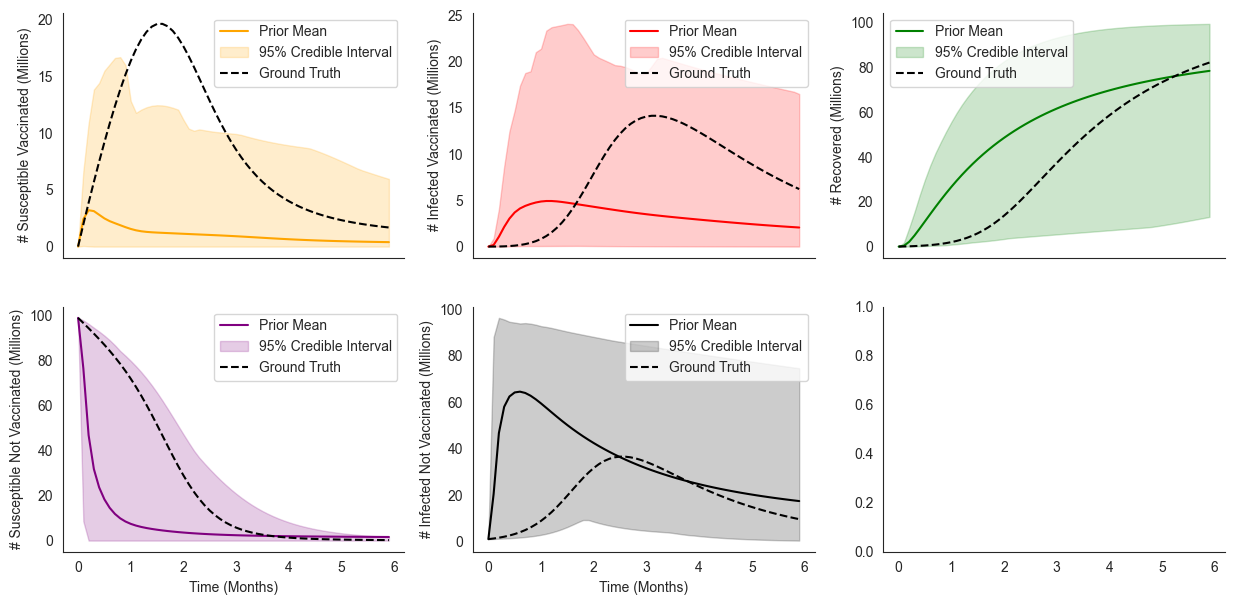

In [12]:

fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True)

SIRV_plot(
    logging_times,
    sirv_prior_samples["S_V"],
    sirv_true_traj["S_V"],
    "# Susceptible Vaccinated (Millions)",
    "orange",
    "Ground Truth",
    ax[0, 0],
    legend=True,
    test_plot=False,
    mean_label="Prior Mean",
)

SIRV_plot(
    logging_times,
    sirv_prior_samples["S_nV"],
    sirv_true_traj["S_nV"],
    "# Susceptible Not Vaccinated (Millions)",
    "purple",
    "Ground Truth",
    ax[1, 0],
    legend=True,
    test_plot=False,
    mean_label="Prior Mean",
)

SIRV_plot(
    logging_times,
    sirv_prior_samples["I_V"],
    sirv_true_traj["I_V"],
    "# Infected Vaccinated (Millions)",
    "red",
    "Ground Truth",
    ax[0, 1],
    legend=True,
    test_plot=False,
    mean_label="Prior Mean",
)

SIRV_plot(
    logging_times,
    sirv_prior_samples["I_nV"],
    sirv_true_traj["I_nV"],
    "# Infected Not Vaccinated (Millions)",
    "black",
    "Ground Truth",
    ax[1, 1],
    legend=True,
    test_plot=False,
    mean_label="Prior Mean",
)

SIRV_plot(
    logging_times,
    sirv_prior_samples["R"],
    sirv_true_traj["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[0, 2],
    legend=True,
    test_plot=False,
    mean_label="Prior Mean",
)

# TODO: remove bottom right subplot.

Here, we can see that without any data our prior has induced extremely broad uncertainty over resulting disease dynamics.

## Probabilistic Inference over Dynamical System Parameters

One of the major benefits of writing our dynamical systems model in Pyro and ChiRho is that we can leverage Pyro's support for (partially) automated probabilistic inference. In this section we'll (i) condition on observational data using the `StaticBatchObservation` effect handler and (ii) optimize a variational approximation to the posterior using Pyro's SVI utilities.

In [13]:
def conditioned_sir(obs_times, data, init_state, start_time, base_model=SIRVDynamics, observation_model=sirv_observation_model) -> None:
    sir = bayesian_sirv(base_model)
    obs = condition(data=data)(observation_model)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])

# Define a helper function to run SVI. (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(model, num_steps=num_steps, verbose=True, lr=.03, vi_family=AutoMultivariateNormal, guide=None, **model_kwargs):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 100 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [14]:
# Run inference to approximate the posterior distribution of the SIR model parameters
sirv_guide = run_svi_inference(
    conditioned_sir,
    num_steps=num_steps,
    obs_times=obs_logging_times,
    data=sirv_data,
    init_state=init_state,
    start_time=start_time,
)

[iteration 0001] loss: 2774.8840
[iteration 0100] loss: 606.1091
[iteration 0200] loss: 523.8712


### Informal Posterior Predictive Check - Visualizing Samples

Now that we've approximated the posterior distribution over parameters, let's see how the posterior samples compare to the ground truth parameters and disease trajectories.

In [15]:
# Generate samples from the posterior predictive distribution
sirv_predictive = Predictive(simulated_bayesian_sirv, guide=sirv_guide, num_samples=num_samples, parallel=True)
sirv_posterior_samples = sirv_predictive(init_state, start_time, logging_times)

Text(0.5, 0, 'Alpha')

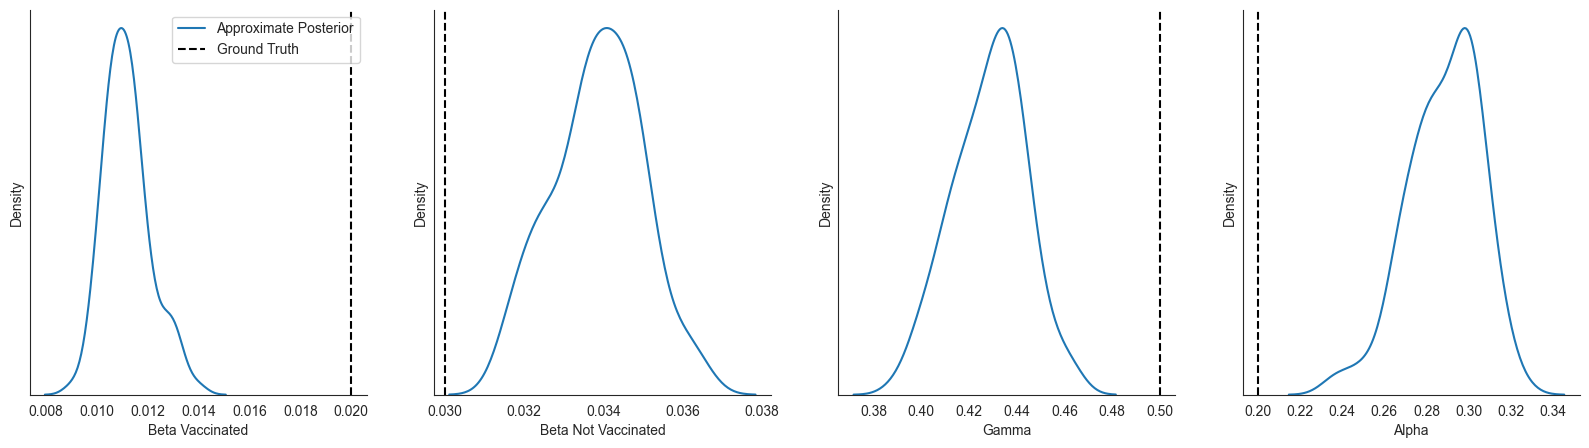

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.kdeplot(sirv_posterior_samples["beta_V"], label="Approximate Posterior", ax=ax[0])
ax[0].axvline(beta_V_true, color="black", label="Ground Truth", linestyle="--")
sns.despine()
ax[0].set_yticks([])
ax[0].legend(loc="upper right")
ax[0].set_xlabel("Beta Vaccinated")

sns.kdeplot(sirv_posterior_samples["beta_nV"], ax=ax[1])
ax[1].axvline(beta_nV_true, color="black", linestyle="--")
sns.despine()
ax[1].set_yticks([])
ax[1].set_xlabel("Beta Not Vaccinated")

sns.kdeplot(sirv_posterior_samples["gamma"], ax=ax[2])
ax[2].axvline(gamma_true, color="black", linestyle="--")
sns.despine()
ax[2].set_yticks([])
ax[2].set_xlabel("Gamma")

sns.kdeplot(sirv_posterior_samples["alpha"], ax=ax[3])
ax[3].axvline(alpha_true, color="black", linestyle="--")
sns.despine()
ax[3].set_yticks([])
ax[3].set_xlabel("Alpha")

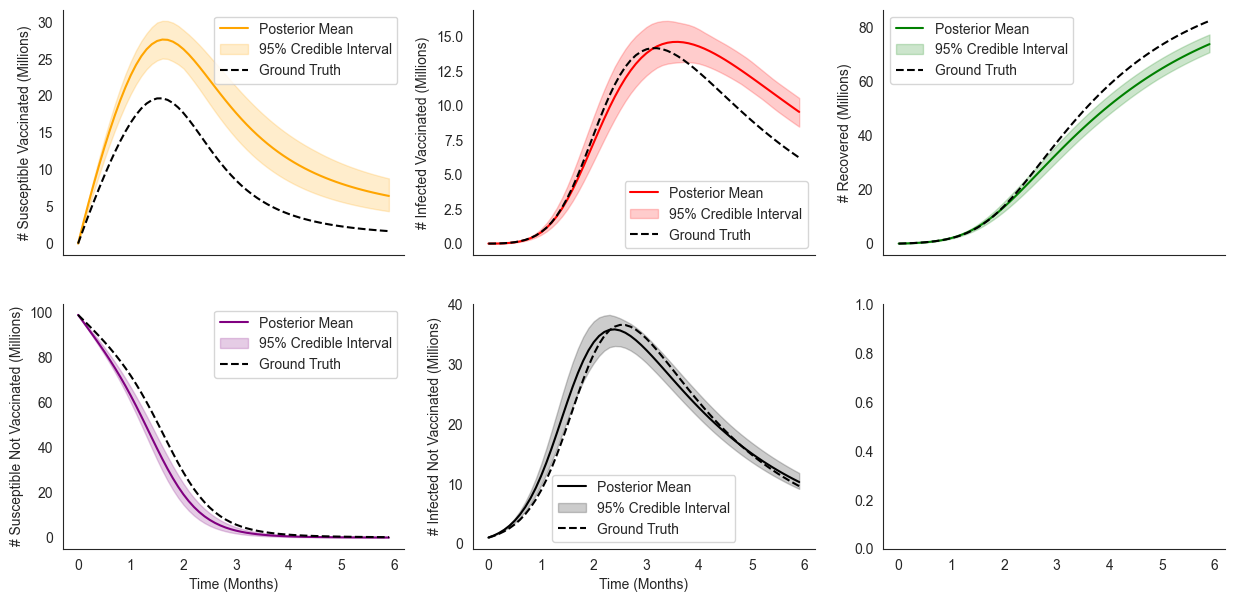

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7), sharex=True)

SIRV_plot(
    logging_times,
    sirv_posterior_samples["S_V"],
    sirv_true_traj["S_V"],
    "# Susceptible Vaccinated (Millions)",
    "orange",
    "Ground Truth",
    ax[0, 0],
    legend=True,
    test_plot=False,
    mean_label="Posterior Mean",
)

SIRV_plot(
    logging_times,
    sirv_posterior_samples["S_nV"],
    sirv_true_traj["S_nV"],
    "# Susceptible Not Vaccinated (Millions)",
    "purple",
    "Ground Truth",
    ax[1, 0],
    legend=True,
    test_plot=False,
    mean_label="Posterior Mean",
)

SIRV_plot(
    logging_times,
    sirv_posterior_samples["I_V"],
    sirv_true_traj["I_V"],
    "# Infected Vaccinated (Millions)",
    "red",
    "Ground Truth",
    ax[0, 1],
    legend=True,
    test_plot=False,
    mean_label="Posterior Mean",
)

SIRV_plot(
    logging_times,
    sirv_posterior_samples["I_nV"],
    sirv_true_traj["I_nV"],
    "# Infected Not Vaccinated (Millions)",
    "black",
    "Ground Truth",
    ax[1, 1],
    legend=True,
    test_plot=False,
    mean_label="Posterior Mean",
)

SIRV_plot(
    logging_times,
    sirv_posterior_samples["R"],
    sirv_true_traj["R"],
    "# Recovered (Millions)",
    "green",
    "Ground Truth",
    ax[0, 2],
    legend=True,
    test_plot=False,
    mean_label="Posterior Mean",
)

# TODO: remove bottom right subplot.

## Mediation Analysis

In [18]:
from chirho.counterfactual.handlers import MultiWorldCounterfactual, TwinWorldCounterfactual
from chirho.interventional.handlers import do

def mediation_sirv(init_state, start_time, logging_times):
    
    # Double the vaccination rate
    with MultiWorldCounterfactual() as cf:
        with do(actions = {"alpha": lambda x: 2 * x}):
            trajectory = simulated_bayesian_sirv(init_state, start_time, logging_times)
            print(indices_of(trajectory))

In [108]:
mediation_sirv_predictive = Predictive(mediation_sirv, guide=sirv_guide, num_samples=num_samples, parallel=True)
mediation_sirv_posterior_samples = mediation_sirv_predictive(init_state, start_time, logging_times)

IndexSet({'alpha': {0, 1}})
IndexSet({'alpha': {0, 1}})


RuntimeError: The size of tensor a (28) must match the size of tensor b (20) at non-singleton dimension 0
Trace Shapes:  
 Param Sites:  
Sample Sites:  
  beta_V dist |
        value |
 beta_nV dist |
        value |
   gamma dist |
        value |
   alpha dist |
        value |

In [72]:
mediation_sirv_posterior_samples["S_V"].shape

torch.Size([100, 2, 1, 1, 1, 1, 60])

In [36]:
# from chirho.counterfactual.handlers import MultiWorldCounterfactual
# from chirho.indexed.ops import gather, IndexSet

# mediation_time = torch.tensor(2.0)

# def mediation_sir(lockdown_start, 
#                   mediation_time, 
#                   lockdown_strength, 
#                   init_state, 
#                   start_time, 
#                   logging_times) -> State[torch.Tensor]:
#     with TwinWorldCounterfactual():
#         factual_state_func = lambda state_var: gather(state_var, IndexSet(intervened={0}), event_dim=0)
#         mediation_intervention = dict(l=factual_state_func)
#         with StaticIntervention(time=mediation_time, intervention=mediation_intervention):
#             trajectory = intervened_sir(lockdown_start, lockdown_strength, init_state, start_time, logging_times)

#         factual = {k: pyro.deterministic(f"factual_{k}", v.squeeze())
#                     for k, v in gather(trajectory, IndexSet(intervened={0}), event_dim=1).items()}
#         counterfactual = {k: pyro.deterministic(f"counterfactual_{k}", v.squeeze())
#                           for k, v in gather(trajectory, IndexSet(intervened={1}), event_dim=1).items()}
        
#         return factual, counterfactual
    
# factual, counterfactual = mediation_sir(lockdown_start, mediation_time, lockdown_strength, init_state_lockdown, start_time, logging_times)

In [37]:


# true_mediation_sir = pyro.condition(mediation_sirv, data={"beta": beta_true, "gamma": gamma_true})
# true_mediation_trajectory_factual, true_mediation_trajectory_counterfactual = true_mediation_sir(lockdown_start, mediation_time, lockdown_strength, init_state_lockdown, start_time, logging_times)

In [38]:
# # Plot predicted values for S, I, and R with 95% credible intervals

# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# SIR_plot(
#     logging_times,
#     mediation_sir_posterior_samples["counterfactual_S"] - mediation_sir_posterior_samples["factual_S"],
#     true_mediation_trajectory_counterfactual["S"] - true_mediation_trajectory_factual["S"],
#     "# Susceptible (Millions)",
#     "orange",
#     "True Drift Trajectory - No Mediation",
#     ax[0],
#     legend=True,
#     test_plot=False,
# )
# SIR_plot(
#     logging_times,
#     mediation_sir_posterior_samples["counterfactual_I"] - mediation_sir_posterior_samples["factual_I"],
#     true_mediation_trajectory_counterfactual["I"] - true_mediation_trajectory_factual["I"],
#     "# Infected (Millions)",
#     "red",
#     "True Drift Trajectory - No Mediation",
#     ax[1],
#     legend=True,
#     test_plot=False,
# )
# SIR_plot(
#     logging_times,
#     mediation_sir_posterior_samples["counterfactual_R"] - mediation_sir_posterior_samples["factual_R"],
#     true_mediation_trajectory_counterfactual["R"] - true_mediation_trajectory_factual["R"],
#     "# Recovered (Millions)",
#     "green",
#     "True Drift Trajectory - No Mediation",
#     ax[2],
#     legend=True,
#     test_plot=False,
# )

# # Plot the static intervention
# for a in ax:
#     a.axvline(lockdown_start, color="grey", linestyle="-", label="Start of Lockdown")
#     a.axvline(mediation_time, color="grey", linestyle="-", label="Mediation Time")
#     a.legend()